In [16]:

from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Input, Embedding, GRU, Flatten
from tensorflow.keras import Model

import time
import numpy as np
import sys
import io
import os
import codecs
import random
import json
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

import pickle 
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

# URLs

In [6]:
sutras_fp = str(os.getcwd()) + r'\datasets\Sutras\Sutras_full.txt'
vedas_fp = str(os.getcwd()) + r'\datasets\Vedas\vedas.txt'
quran_fp = str(os.getcwd()) + r'\datasets\Quran\quran.txt'
tanakh_fp = str(os.getcwd()) + r'\datasets\Tanakh\Pentateuch_full.txt'
bible_fp = str(os.getcwd()) + r'\datasets\Bible\bible.txt'
#religious_texts_fp = str(os.getcwd()) + r'\datasets\religious_texts'

In [7]:

SEQUENCE_LEN = 10
MIN_WORD_FREQUENCY = 5
STEP = 1
BATCH_SIZE = 512


In [8]:
class TextData():
    def __init__(self, corpus_file):
        self.text = None
        self.tokens = None
        self.token_freq = None
        self.clean_text = None
        """Takes a corpus filename, opens a utf-8 file, """

        with io.open(corpus_file, encoding='utf-8') as f:
            self.text = f.read().lower().replace('\n', ' \n ')
            self.text = self.text.replace('\t', '')

            print('Corpus length in characters:', len(self.text))     
        self.corpus_len = len(self.text)
        print('Loaded corpus...')

    
    def get_token_freq(self):
        # Calculate word frequency
        self.token_freq = {}
        for token in self.tokens:
            self.token_freq[token] =  self.token_freq.get(token, 0) + 1
        return self.token_freq
    
    def get_char_freq(self):
        # Calculate word frequency
        self.char_freq = {}
        for char in self.text:
            self.char_freq[char] =  self.char_freq.get(char, 0) + 1
        return self.char_freq

    
    def tokenize(self):
        self.tokens = [w for w in self.text.split(' ') if w.strip() != '' or w == '\n']
        print('Corpus length in words:', len(self.tokens))
        return self.tokens
    


    

In [9]:
def drop_chars(txt):
    #return re.sub('[^A-Za-z0-9.,?!" -–]+', '', txt)
    return re.sub('[^A-Za-z0-9 ]+', '', txt)

In [10]:
def get_ignorable_words(word_freq):
    ignored_words = set()
    for k, v in word_freq.items():
        if word_freq[k] < MIN_WORD_FREQUENCY:
            ignored_words.add(k)
    return ignored_words


def get_words(text_in_words, ignored_words):
    words = set(text_in_words)
    print('Unique words before ignoring:', len(words))
    print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
    words = sorted(set(words) - ignored_words)
    print('Unique words after ignoring:', len(words))
    return words

In [11]:

def get_translate_dicts(words):
    word_indices = dict((c, i) for i, c in enumerate(words))
    indices_word = dict((i, c) for i, c in enumerate(words))
    return word_indices, indices_word


def get_training_data(text_in_words, ignored_words):
    # cut the text in semi-redundant sequences of SEQUENCE_LEN words
    sentences = []
    next_words = []
    ignored = 0
    for i in range(0, len(text_in_words) - SEQUENCE_LEN, STEP):
        # Only add the sequences where no word is in ignored_words
        if len(set(text_in_words[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
            sentences.append(text_in_words[i: i + SEQUENCE_LEN])
            next_words.append(text_in_words[i + SEQUENCE_LEN])
        else:
            ignored = ignored + 1
    print('Ignored sequences:', ignored)
    print('Remaining sequences:', len(sentences))
    return sentences, next_words


def get_training_data_one_list(text_in_words, ignored_words):
    # cut the text in semi-redundant sequences of SEQUENCE_LEN words
    text = []
    ignored = 0
    for i in text_in_words:
        # Only add the sequences where no word is in ignored_words
        if i not in ignored_words:
            text.append(i)
        else:
            ignored = ignored + 1
    print('Ignored sequences:', ignored)
    print('Remaining sequences:', len(text))
    return text

In [12]:
def log_vocabulary(words_file_path, words_set):
    """Takes a filepath and a list, and creates a text file to log that word list"""
    words_file = codecs.open(words_file_path, 'w', encoding='utf8')
    for w in words_set:
        if w != "\n":
            words_file.write(w+"\n")
        else:
            words_file.write(w)
    words_file.close()
    
    
def plot_log_char_freq(char_freq, word_freq):
    df1 = pd.DataFrame(char_freq, index = [0])
    df2 = pd.DataFrame(word_freq, index = [0])
    fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20,8));
   
    ax1.bar(range(len(df1.columns)),np.log(df1.iloc[0].values), width = 2);
    ax1.set_title('Character Frequency in the corpus');
    ax1.set_ylabel('Log Scale of Frequency');
    ax1.set_xlabel('Character');

    ax2.bar(range(len(df2.columns)),np.log(df2.iloc[0].values), width = 2);
    ax2.set_title('Word Frequency in the corpus');
    ax2.set_ylabel('Log Scale of Frequency');
    ax2.set_xlabel('Word');
    


In [13]:
sutras = TextData(sutras_fp)
vedas = TextData(vedas_fp)
bible = TextData(bible_fp)
tanakh = TextData(tanakh_fp)
quran = TextData(quran_fp)

Corpus length in characters: 7915214
Loaded corpus...
Corpus length in characters: 3808286
Loaded corpus...
Corpus length in characters: 4552748
Loaded corpus...
Corpus length in characters: 869286
Loaded corpus...
Corpus length in characters: 764579
Loaded corpus...


# Sutras

1. Set up, preprocess, clean, and plot initial EDA

In [14]:

## First drop and replace some bad characters to make the analysis simpler and more effective
sutras.text = drop_chars(sutras.text)
#Get and count the frequency of each character after cleaning
sutras_char_freq = sutras.get_char_freq()

#Basically split into words (words are tokens here)
sutras_tokens = sutras.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
sutras_freq = sutras.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
sutras_ignored_words = get_ignorable_words(sutras_freq) #ignored words less than frequency
sutras_kept_words = get_words(sutras_tokens, sutras_ignored_words) #keep words


#Get translation tables for kept tokens
sutras_encoder, sutras_decoder = get_translate_dicts(sutras_kept_words) #get translation tables
print("Encoder Table:\n",list(sutras_encoder.items())[:10],"\nDecoder Table:\n", list(sutras_decoder.items())[:10])

#Get the frequency of each word after pruning
sutras_kept_freq = dict(zip(sutras_kept_words,[sutras_freq[value] for value in sutras_kept_words]))

Corpus length in words: 1318748
Unique words before ignoring: 28369
Ignoring words with frequency < 5
Unique words after ignoring: 10205
Encoder Table:
 [('1', 0), ('10', 1), ('100', 2), ('1000', 3), ('102', 4), ('103', 5), ('104', 6), ('106', 7), ('107', 8), ('108', 9)] 
Decoder Table:
 [(0, '1'), (1, '10'), (2, '100'), (3, '1000'), (4, '102'), (5, '103'), (6, '104'), (7, '106'), (8, '107'), (9, '108')]


In [18]:
save_obj(sutras_kept_freq,'sutras_kept_freq')

In [144]:
s = pd.DataFrame(sutras_kept_freq, index = [0]).T
s.sort_values(by= [0])[-50:-1]

,0
so,3296
which,3493
him,3538
an,3539
no,3551
their,3595
said,3644
these,3654
thus,3678
should,3770


In [ ]:
plot_log_char_freq(sutras_char_freq, sutras_kept_freq)


# Vedas

In [19]:

## First drop and replace some bad characters to make the analysis simpler and more effective
vedas.text = drop_chars(vedas.text)
#Get and count the frequency of each character after cleaning
vedas_char_freq = vedas.get_char_freq()

#Basically split into words (words are tokens here)
vedas_tokens = vedas.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
vedas_freq = vedas.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
vedas_ignored_words = get_ignorable_words(vedas_freq) #ignored words less than frequency
vedas_kept_words = get_words(vedas_tokens, vedas_ignored_words) #keep words


#Get translation tables for kept tokens
vedas_encoder, vedas_decoder = get_translate_dicts(vedas_kept_words) #get translation tables
print("Encoder Table:\n",list(vedas_encoder.items())[:10],"\nDecoder Table:\n", list(vedas_decoder.items())[:10])

#Get the frequency of each word after pruning
vedas_kept_freq = dict(zip(vedas_kept_words,[vedas_freq[value] for value in vedas_kept_words]))

Corpus length in words: 629129
Unique words before ignoring: 20324
Ignoring words with frequency < 5
Unique words after ignoring: 6016
Encoder Table:
 [('0', 0), ('1', 1), ('10', 2), ('1009', 3), ('1010', 4), ('1021', 5), ('1022', 6), ('1023', 7), ('1035', 8), ('1036', 9)] 
Decoder Table:
 [(0, '0'), (1, '1'), (2, '10'), (3, '1009'), (4, '1010'), (5, '1021'), (6, '1022'), (7, '1023'), (8, '1035'), (9, '1036')]


In [20]:
save_obj(vedas_kept_freq,'vedas_kept_freq')

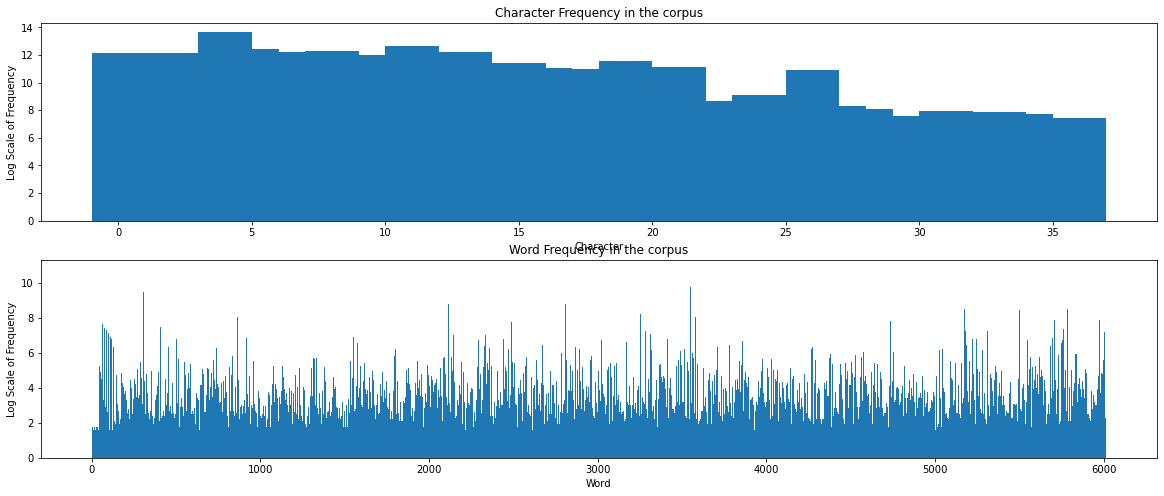

In [19]:
plot_log_char_freq(vedas_char_freq, vedas_kept_freq)


In [145]:
s = pd.DataFrame(vedas_kept_freq, index = [0]).T
s.sort_values(by= [0])[-50:-1]

,0
hath,1814
like,1842
their,1872
one,2009
3,2129
not,2149
sacrifice,2182
2,2331
have,2372
hymn,2434


# Bible

In [21]:

## First drop and replace some bad characters to make the analysis simpler and more effective
bible.text = drop_chars(bible.text)
#Get and count the frequency of each character after cleaning
bible_char_freq = bible.get_char_freq()

#Basically split into words (words are tokens here)
bible_tokens = bible.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
bible_freq = bible.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
bible_ignored_words = get_ignorable_words(bible_freq) #ignored words less than frequency
bible_kept_words = get_words(bible_tokens, bible_ignored_words) #keep words


#Get translation tables for kept tokens
bible_encoder, bible_decoder = get_translate_dicts(bible_kept_words) #get translation tables
print("Encoder Table:\n",list(bible_encoder.items())[:10],"\nDecoder Table:\n", list(bible_decoder.items())[:10])

#Get the frequency of each word after pruning
bible_kept_freq = dict(zip(bible_kept_words,[bible_freq[value] for value in bible_kept_words]))

Corpus length in words: 824172
Unique words before ignoring: 16948
Ignoring words with frequency < 5
Unique words after ignoring: 6829
Encoder Table:
 [('101', 0), ('1010', 1), ('1011', 2), ('1012', 3), ('1013', 4), ('1014', 5), ('1015', 6), ('1016', 7), ('1017', 8), ('1018', 9)] 
Decoder Table:
 [(0, '101'), (1, '1010'), (2, '1011'), (3, '1012'), (4, '1013'), (5, '1014'), (6, '1015'), (7, '1016'), (8, '1017'), (9, '1018')]


In [22]:
save_obj(bible_kept_freq,'bible_kept_freq')

In [ ]:
plot_log_char_freq(bible_char_freq, bible_kept_freq)


In [146]:
s = pd.DataFrame(bible_kept_freq, index = [0]).T
s.sort_values(by= [0])[-50:-1]

,0
up,2383
israel,2565
man,2613
by,2644
you,2683
upon,2750
were,2773
out,2776
this,2835
when,2836


# Tanakh

In [23]:

## First drop and replace some bad characters to make the analysis simpler and more effective
tanakh.text = drop_chars(tanakh.text)
#Get and count the frequency of each character after cleaning
tanakh_char_freq = tanakh.get_char_freq()

#Basically split into words (words are tokens here)
tanakh_tokens = tanakh.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
tanakh_freq = tanakh.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
tanakh_ignored_words = get_ignorable_words(tanakh_freq) #ignored words less than frequency
tanakh_kept_words = get_words(tanakh_tokens, tanakh_ignored_words) #keep words


#Get translation tables for kept tokens
tanakh_encoder, tanakh_decoder = get_translate_dicts(tanakh_kept_words) #get translation tables
print("Encoder Table:\n",list(tanakh_encoder.items())[:10],"\nDecoder Table:\n", list(tanakh_decoder.items())[:10])

#Get the frequency of each word after pruning
tanakh_kept_freq = dict(zip(tanakh_kept_words,[tanakh_freq[value] for value in tanakh_kept_words]))

Corpus length in words: 162580
Unique words before ignoring: 6789
Ignoring words with frequency < 5
Unique words after ignoring: 2397
Encoder Table:
 [('101', 0), ('1010', 1), ('1011', 2), ('1012', 3), ('1013', 4), ('1014', 5), ('1015', 6), ('1016', 7), ('1017', 8), ('1018', 9)] 
Decoder Table:
 [(0, '101'), (1, '1010'), (2, '1011'), (3, '1012'), (4, '1013'), (5, '1014'), (6, '1015'), (7, '1016'), (8, '1017'), (9, '1018')]


In [24]:
save_obj(tanakh_kept_freq,'tanakh_kept_freq')

In [ ]:
plot_log_char_freq(tanakh_char_freq, tanakh_kept_freq)


In [147]:
s = pd.DataFrame(tanakh_kept_freq, index = [0]).T
s.sort_values(by= [0])[-50:-1]

,0
were,504
as,524
have,528
your,538
offering,546
me,549
this,550
my,565
you,575
israel,576


# Quran

In [25]:

## First drop and replace some bad characters to make the analysis simpler and more effective
quran.text = drop_chars(quran.text)
#Get and count the frequency of each character after cleaning
quran_char_freq = quran.get_char_freq()

#Basically split into words (words are tokens here)
quran_tokens = quran.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
quran_freq = quran.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
quran_ignored_words = get_ignorable_words(quran_freq) #ignored words less than frequency
quran_kept_words = get_words(quran_tokens, quran_ignored_words) #keep words


#Get translation tables for kept tokens
quran_encoder, quran_decoder = get_translate_dicts(quran_kept_words) #get translation tables
print("Encoder Table:\n",list(quran_encoder.items())[:10],"\nDecoder Table:\n", list(quran_decoder.items())[:10])

#Get the frequency of each word after pruning
quran_kept_freq = dict(zip(quran_kept_words,[quran_freq[value] for value in quran_kept_words]))

Corpus length in words: 139057
Unique words before ignoring: 6962
Ignoring words with frequency < 5
Unique words after ignoring: 1981
Encoder Table:
 [('a', 0), ('aad', 1), ('aaron', 2), ('abandon', 3), ('abide', 4), ('abiding', 5), ('able', 6), ('abode', 7), ('about', 8), ('above', 9)] 
Decoder Table:
 [(0, 'a'), (1, 'aad'), (2, 'aaron'), (3, 'abandon'), (4, 'abide'), (5, 'abiding'), (6, 'able'), (7, 'abode'), (8, 'about'), (9, 'above')]


In [26]:
save_obj(quran_kept_freq,'quran_kept_freq')

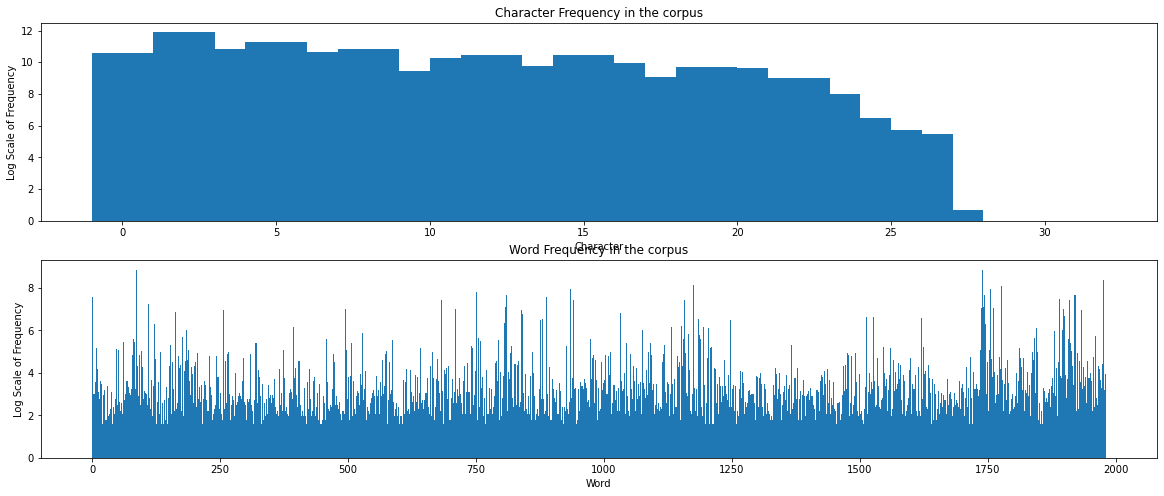

In [21]:
plot_log_char_freq(quran_char_freq, quran_kept_freq)


In [148]:
s = pd.DataFrame(quran_kept_freq, index = [0]).T
s.sort_values(by= [0])[-50:-1]

,0
our,445
us,446
day,463
my,479
or,480
no,504
as,534
then,554
has,580
i,650


#  Encode

## Sutras

In [23]:
# sutras_sentences, sutras_next_words = get_training_data(sutras_tokens, sutras_ignored_words)

# #Set up the full encoded training list
# sutras_encoded = []

# #Update the list with the encoded values
# for seq in sutras_sentences:
#     int_sutras_encode = []
#     for v in seq:
#         int_sutras_encode.append(sutras_encoder[v])
#     sutras_encoded.append(int_sutras_encode)


Ignored sequences: 236873
Remaining sequences: 1081865


In [16]:
sutras_t = get_training_data_one_list(sutras_tokens, sutras_ignored_words)
print('Original Text in Words Length: ',len(sutras_tokens))
print('After Ignored Words Text in Words Length: ',len(sutras_t))

Ignored sequences: 30180
Remaining sequences: 1288568
Original Text in Words Length:  1318748
After Ignored Words Text in Words Length:  1288568


In [130]:
sutras_t[50000:50050]

['in',
 'its',
 'consummation',
 'doth',
 'he',
 'proclaim',
 'both',
 'in',
 'the',
 'spirit',
 'and',
 'in',
 'the',
 'letter',
 'the',
 'higher',
 'life',
 'doth',
 'he',
 'make',
 'known',
 'in',
 'all',
 'its',
 'fullness',
 'and',
 'in',
 'all',
 'its',
 'purity',
 'and',
 'good',
 'is',
 'it',
 'to',
 'pay',
 'visits',
 'to',
 'arahats',
 'like',
 'that',
 '3',
 'now',
 'at',
 'that',
 'time',
 'a',
 'young',
 'brahman',
 'an']

## Vedas

In [17]:
# vedas_sentences, vedas_next_words = get_training_data(vedas_tokens, vedas_ignored_words)

# #Set up the full encoded training list
# vedas_encoded = []

# #Update the list with the encoded values
# for seq in vedas_sentences:
#     int_vedas_encode = []
#     for v in seq:
#         int_vedas_encode.append(vedas_encoder[v])
#     vedas_encoded.append(int_vedas_encode)


In [18]:
vedas_t = get_training_data_one_list(vedas_tokens, vedas_ignored_words)
print('Original Text in Words Length: ',len(vedas_tokens))
print('After Ignored Words Text in Words Length: ',len(vedas_t))

Ignored sequences: 23711
Remaining sequences: 605418
Original Text in Words Length:  629129
After Ignored Words Text in Words Length:  605418


## Bible

In [19]:
# bible_sentences, bible_next_words = get_training_data(bible_tokens, bible_ignored_words)

# #Set up the full encoded training list
# bible_encoded = []

# #Update the list with the encoded values
# for seq in bible_sentences:
#     int_bible_encode = []
#     for v in seq:
#         int_bible_encode.append(bible_encoder[v])
#     bible_encoded.append(int_bible_encode)


In [20]:
bible_t = get_training_data_one_list(bible_tokens, bible_ignored_words)
print('Original Text in Words Length: ',len(bible_tokens))
print('After Ignored Words Text in Words Length: ',len(bible_t))

Ignored sequences: 17366
Remaining sequences: 806806
Original Text in Words Length:  824172
After Ignored Words Text in Words Length:  806806


## Tanakh

In [21]:
# tanakh_sentences, tanakh_next_words = get_training_data(tanakh_tokens, tanakh_ignored_words)

# #Set up the full encoded training list
# tanakh_encoded = []

# #Update the list with the encoded values
# for seq in tanakh_sentences:
#     int_tanakh_encode = []
#     for v in seq:
#         int_tanakh_encode.append(tanakh_encoder[v])
#     tanakh_encoded.append(int_tanakh_encode)


In [22]:
tanakh_t = get_training_data_one_list(tanakh_tokens, tanakh_ignored_words)
print('Original Text in Words Length: ',len(tanakh_tokens))
print('After Ignored Words Text in Words Length: ',len(tanakh_t))

Ignored sequences: 8047
Remaining sequences: 154533
Original Text in Words Length:  162580
After Ignored Words Text in Words Length:  154533


## Quran

In [23]:
# quran_sentences, quran_next_words = get_training_data(quran_tokens, quran_ignored_words)

# #Set up the full encoded training list
# quran_encoded = []

# #Update the list with the encoded values
# for seq in quran_sentences:
#     int_quran_encode = []
#     for v in seq:
#         int_quran_encode.append(quran_encoder[v])
#     quran_encoded.append(int_quran_encode)


In [24]:
quran_t = get_training_data_one_list(quran_tokens, quran_ignored_words)
print('Original Text in Words Length: ',len(quran_tokens))
print('After Ignored Words Text in Words Length: ',len(quran_t))

Ignored sequences: 8380
Remaining sequences: 130677
Original Text in Words Length:  139057
After Ignored Words Text in Words Length:  130677


In [68]:
sutras_encoded_t = [sutras_encoder[i] for i in sutras_t]
vedas_encoded_t = [vedas_encoder[i] for i in vedas_t]
bible_encoded_t = [bible_encoder[i] for i in bible_t]
tanakh_encoded_t = [tanakh_encoder[i] for i in tanakh_t]
quran_encoded_t = [quran_encoder[i] for i in quran_t]


# Embedding

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate
from tensorflow.keras.layers import Embedding, dot, Dot
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np


    

In [112]:
losses = {'sutras':[],
         'vedas':[],
         'bible':[],
         'tanakh':[],
         'quran':[]}


window_size = 6
vector_dim = 150
epochs = 250000

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Sutras Setup

In [113]:
#The size of each vocabulary of each text
vocab_size = len(sutras_encoder)



sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sutras_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[9087, 2941], [8118, 2117], [2281, 258], [9862, 9190], [8210, 2426], [1301, 5743], [6144, 7062], [4190, 8997], [4915, 4524], [9040, 9087]] [0, 0, 1, 0, 0, 0, 0, 1, 1, 1]


In [132]:
word_context

array([ 796,  569,  652, ...,  256,  200, 1205])

In [114]:
import tensorflow.keras.backend as K

# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)

    if cnt % 1000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        losses['sutras'].append((cnt,loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

model.save_weights(str('./weights/'+'sutras'+'.h5'))
save_obj(losses, 'losses')

Iteration 0, loss=0.24973024427890778
Iteration 1000, loss=0.25718575716018677
Iteration 2000, loss=0.25558632612228394
Iteration 3000, loss=0.2433577924966812
Iteration 4000, loss=0.260622501373291
Iteration 5000, loss=0.25719791650772095
Iteration 6000, loss=0.23097988963127136
Iteration 7000, loss=0.20916429162025452
Iteration 8000, loss=0.3073486089706421
Iteration 9000, loss=0.19192072749137878
Iteration 10000, loss=0.19433946907520294
Iteration 11000, loss=0.18392619490623474
Iteration 12000, loss=6.10245388088515e-06
Iteration 13000, loss=0.07408968359231949
Iteration 14000, loss=0.15859222412109375
Iteration 15000, loss=0.0
Iteration 16000, loss=0.14458470046520233
Iteration 17000, loss=0.16416716575622559
Iteration 18000, loss=0.0
Iteration 19000, loss=0.14185231924057007
Iteration 20000, loss=0.40220674872398376
Iteration 21000, loss=1.080570655176416e-08
Iteration 22000, loss=0.12044154107570648
Iteration 23000, loss=0.12080275267362595
Iteration 24000, loss=0.41849479079246

# Vedas Setup

In [115]:
#The size of each vocabulary of each text
vocab_size = len(vedas_encoder)

sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(vedas_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[5279, 103], [416, 5499], [4353, 2704], [5847, 3730], [5177, 3000], [3551, 487], [3506, 4431], [5177, 4907], [2998, 5284], [2470, 4131]] [0, 0, 0, 0, 1, 1, 0, 0, 0, 1]


In [116]:


# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)

    if cnt % 1000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        losses['vedas'].append((cnt,loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

model.save_weights(str('./weights/'+'vedas'+'.h5'))
save_obj(losses, 'losses')

Iteration 0, loss=0.24736115336418152
Iteration 1000, loss=0.24113285541534424
Iteration 2000, loss=0.24639952182769775
Iteration 3000, loss=0.2547740936279297
Iteration 4000, loss=0.26288464665412903
Iteration 5000, loss=0.2423153668642044
Iteration 6000, loss=0.2388557493686676
Iteration 7000, loss=0.2458762377500534
Iteration 8000, loss=0.2385142296552658
Iteration 9000, loss=0.2505006790161133
Iteration 10000, loss=0.2453857958316803
Iteration 11000, loss=0.2425558716058731
Iteration 12000, loss=0.25083354115486145
Iteration 13000, loss=0.24563181400299072
Iteration 14000, loss=0.2528590261936188
Iteration 15000, loss=0.2404453158378601
Iteration 16000, loss=0.25183531641960144
Iteration 17000, loss=0.25450819730758667
Iteration 18000, loss=0.2967410981655121
Iteration 19000, loss=0.22757062315940857
Iteration 20000, loss=0.2662801444530487
Iteration 21000, loss=0.23045112192630768
Iteration 22000, loss=0.2670726776123047
Iteration 23000, loss=0.2222745418548584
Iteration 24000, lo

# Bible Setup

In [117]:
#The size of each vocabulary of each text
vocab_size = len(bible_encoder)

sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(bible_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[6177, 1642], [6217, 4286], [6177, 4703], [3723, 2977], [1778, 2918], [4776, 385], [6276, 6607], [4703, 5845], [3628, 6757], [4567, 6181]] [0, 1, 1, 0, 1, 0, 1, 0, 0, 1]


In [118]:

# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)

    if cnt % 1000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        losses['bible'].append((cnt,loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

model.save_weights(str('./weights/'+'bible'+'.h5'))
save_obj(losses, 'losses')

Iteration 0, loss=0.2497856169939041
Iteration 1000, loss=0.24721525609493256
Iteration 2000, loss=0.23643669486045837
Iteration 3000, loss=0.25573065876960754
Iteration 4000, loss=0.2564864754676819
Iteration 5000, loss=0.26956576108932495
Iteration 6000, loss=0.2736494541168213
Iteration 7000, loss=0.21736405789852142
Iteration 8000, loss=0.29998645186424255
Iteration 9000, loss=0.23716172575950623
Iteration 10000, loss=0.1738279014825821
Iteration 11000, loss=0.3043056130409241
Iteration 12000, loss=0.07531508058309555
Iteration 13000, loss=0.41526609659194946
Iteration 14000, loss=0.11638853698968887
Iteration 15000, loss=0.26964467763900757
Iteration 16000, loss=0.11312323808670044
Iteration 17000, loss=0.131582111120224
Iteration 18000, loss=0.0
Iteration 19000, loss=0.008011546917259693
Iteration 20000, loss=0.11139557510614395
Iteration 21000, loss=0.12406782805919647
Iteration 22000, loss=0.014561692252755165
Iteration 23000, loss=0.0
Iteration 24000, loss=0.1121792271733284
I

# Tanakh Setup

In [119]:
#The size of each vocabulary of each text
vocab_size = len(tanakh_encoder)

sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(tanakh_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[182, 585], [610, 979], [1026, 2149], [1672, 1155], [2054, 1415], [2234, 1180], [646, 1280], [1805, 538], [963, 1026], [843, 1672]] [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]


In [120]:

# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)

    if cnt % 1000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        losses['tanakh'].append((cnt,loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

model.save_weights(str('./weights/'+'tanakh'+'.h5'))
save_obj(losses, 'losses')

Iteration 0, loss=0.24872258305549622
Iteration 1000, loss=0.23844502866268158
Iteration 2000, loss=0.2441060096025467
Iteration 3000, loss=0.24100995063781738
Iteration 4000, loss=0.24062496423721313
Iteration 5000, loss=0.24936150014400482
Iteration 6000, loss=0.2466319501399994
Iteration 7000, loss=0.25130078196525574
Iteration 8000, loss=0.23519419133663177
Iteration 9000, loss=0.24238820374011993
Iteration 10000, loss=0.2606649696826935
Iteration 11000, loss=0.24435916543006897
Iteration 12000, loss=0.24872031807899475
Iteration 13000, loss=0.24735382199287415
Iteration 14000, loss=0.24655583500862122
Iteration 15000, loss=0.21827882528305054
Iteration 16000, loss=0.26841893792152405
Iteration 17000, loss=0.26090988516807556
Iteration 18000, loss=0.23142556846141815
Iteration 19000, loss=0.24977387487888336
Iteration 20000, loss=0.2601797580718994
Iteration 21000, loss=0.23067401349544525
Iteration 22000, loss=0.21722754836082458
Iteration 23000, loss=0.21048080921173096
Iteration

# Quran Setup

In [121]:
#The size of each vocabulary of each text
vocab_size = len(quran_encoder)

sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(quran_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[1740, 796], [86, 569], [1846, 652], [682, 1975], [841, 257], [1975, 1975], [1624, 97], [1743, 1657], [1975, 810], [1812, 1439]] [0, 0, 0, 1, 1, 1, 0, 0, 1, 0]


# Quran Modeling

In [122]:

# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)

    if cnt % 1000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        losses['quran'].append((cnt,loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

model.save_weights(str('./weights/'+'quran'+'.h5'))
save_obj(losses, 'losses')

Iteration 0, loss=0.25243324041366577
Iteration 1000, loss=0.24677065014839172
Iteration 2000, loss=0.24219286441802979
Iteration 3000, loss=0.24709264934062958
Iteration 4000, loss=0.2373056411743164
Iteration 5000, loss=0.2351531833410263
Iteration 6000, loss=0.24241654574871063
Iteration 7000, loss=0.22974948585033417
Iteration 8000, loss=0.24444930255413055
Iteration 9000, loss=0.23712977766990662
Iteration 10000, loss=0.25728148221969604
Iteration 11000, loss=0.25772929191589355
Iteration 12000, loss=0.18605613708496094
Iteration 13000, loss=0.24840690195560455
Iteration 14000, loss=0.25498345494270325
Iteration 15000, loss=0.24232202768325806
Iteration 16000, loss=0.15729932487010956
Iteration 17000, loss=0.3301025331020355
Iteration 18000, loss=0.24706728756427765
Iteration 19000, loss=0.23765262961387634
Iteration 20000, loss=0.2576124966144562
Iteration 21000, loss=0.17349809408187866
Iteration 22000, loss=0.2487015277147293
Iteration 23000, loss=0.24955739080905914
Iteration 

In [123]:
weights = model.layers[2].get_weights()[0][:]

print(weights.shape)
pd.DataFrame(weights, index=quran_decoder.values()).head()

(1981, 150)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
a,-0.008004,-0.017508,0.019305,-0.035294,-0.013208,-0.018031,-0.009425,0.042773,0.004820,0.031941,...,0.022435,0.028444,0.041003,0.004340,0.012442,0.022538,0.020571,-0.030228,0.009786,-0.035771
aad,-0.043280,0.020593,0.006402,-0.045096,-0.065076,-0.021197,0.042265,-0.001318,-0.115049,-0.039032,...,-0.050158,-0.048636,-0.046291,-0.020075,-0.047856,0.101097,0.045071,0.001910,0.056095,-0.004092
aaron,0.055953,0.014981,-0.016078,0.047872,0.000456,0.016177,-0.039026,-0.007048,0.035373,-0.083134,...,0.046544,-0.012071,-0.036066,-0.011777,-0.006468,0.001492,0.018141,0.006878,-0.088374,0.017967
abandon,0.001636,0.045857,0.012578,-0.020895,-0.004270,0.071471,-0.018808,0.015572,0.045639,0.002846,...,0.036808,-0.005546,0.017284,0.040434,0.055834,0.039540,-0.019949,-0.044315,0.045188,-0.035941
abide,-0.049343,-0.001358,-0.013341,-0.079927,-0.002295,-0.036621,-0.010116,0.024246,-0.046053,0.011096,...,-0.048401,0.001708,-0.084583,0.015470,-0.013865,0.018491,0.050974,0.062327,0.021287,-0.010545


In [124]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [quran_decoder[idx] for idx in distance_matrix[quran_encoder[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['good', 'love', 'creator', 'evil']}

similar_words

(1981, 1981)


{'good': ['attention', 'obvious', 'believers', 'forgiving', 'fairly'],
 'love': ['kindness', 'lesson', 'midst', 'delight', 'deed'],
 'creator': ['dwell', 'clement', 'encounter', 'struck', 'demeaning'],
 'evil': ['hospitality', 'severe', 'during', 'joseph', 'mislead']}

In [125]:
load_obj('losses')

{'sutras': [(0, 0.24973024427890778),
  (1000, 0.25718575716018677),
  (2000, 0.25558632612228394),
  (3000, 0.2433577924966812),
  (4000, 0.260622501373291),
  (5000, 0.25719791650772095),
  (6000, 0.23097988963127136),
  (7000, 0.20916429162025452),
  (8000, 0.3073486089706421),
  (9000, 0.19192072749137878),
  (10000, 0.19433946907520294),
  (11000, 0.18392619490623474),
  (12000, 6.10245388088515e-06),
  (13000, 0.07408968359231949),
  (14000, 0.15859222412109375),
  (15000, 0.0),
  (16000, 0.14458470046520233),
  (17000, 0.16416716575622559),
  (18000, 0.0),
  (19000, 0.14185231924057007),
  (20000, 0.40220674872398376),
  (21000, 1.080570655176416e-08),
  (22000, 0.12044154107570648),
  (23000, 0.12080275267362595),
  (24000, 0.4184947907924652),
  (25000, 0.1622585654258728),
  (26000, 0.11619251221418381),
  (27000, 0.12574687600135803),
  (28000, 0.5550995469093323),
  (29000, 0.35841104388237),
  (30000, 0.037461139261722565),
  (31000, 0.09715898334980011),
  (32000, 0.01581

In [127]:
save_obj(quran_decoder, 'quran_decoder')
save_obj(sutras_decoder, 'sutras_decoder')
save_obj(vedas_decoder, 'vedas_decoder')
save_obj(bible_decoder, 'bible_decoder')
save_obj(tanakh_decoder, 'tanakh_decoder')